In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import src.logs.utils as log
import src.models.model as model_handler
import src.train.main as train_pipeline
import src.models.model as model_handler
from src.train.utils import get_parameters
import src.logs.utils as log
import torch
import gc
import os


In [2]:
log.create_logs_files() 

In [ ]:
EPOCHS = 10
TRIALS = 1

data_config = {
        'load_path': 'data/processed/mm79158.csv',
        'm': 336,
        'n': 14,
        'lookback': 14,
        'horizon': 1,
        'target_col': 'load',
        'time_col': 'datetime',
        'freq': '1h',
        'use_calendar': True,
        'use_weather': True, 
        'device' : 'cuda'
}

train_pipeline.train_model(
    'cnn_di_rnn',
    model_fn=lambda config, p: model_handler.get_cnn_di_rnn(config, p),
    data_config=data_config,
    param_sampler=lambda: get_parameters("cnn_di_rnn"),
    trials=TRIALS,
    epochs=EPOCHS,
    early_stopping=False
)


🔁 Trial 1/1
🔀 Splitting DataFrame with ratios (0.6, 0.1, 0.3)
📊 Split sizes: Train=18153, Val=3025, Test=9078
📏 Scaling univariate data using MinMaxScaler.
🧹 Dropping non-numeric columns from train set: ['datetime']
🧹 Dropping non-numeric columns from val set: ['datetime']
🧹 Dropping non-numeric columns from test set: ['datetime']
✅ Scaling complete. Shapes:
   Train: (18153, 1)
   Val:   (3025, 1)
   Test:  (9078, 1)
🧱 Building traditional sequences (lookback=336, horizon=1, target='load')
  🔄 Progress: 17665/17816 sequences
✅ Sequence creation complete. Total sequences: 17816
🧱 Building traditional sequences (lookback=336, horizon=1, target='load')
  🔄 Progress: 2665/2688 sequences
✅ Sequence creation complete. Total sequences: 2688
🧱 Building traditional sequences (lookback=336, horizon=1, target='load')
  🔄 Progress: 8665/8741 sequences
✅ Sequence creation complete. Total sequences: 8741
⚡ Building periodic inputs aligned with traditional sequences (lookback=336, horizon=1, n=14)


In [4]:
import pandas as pd
import csv

clean_rows = []
expected_columns = 5

with open("logs/trial_info.csv", encoding="utf-8") as f:
    reader = csv.reader(f, quotechar='"', doublequote=True)
    for row in reader:
        if len(row) == expected_columns:
            clean_rows.append(row)

# Define correct column names
columns = ["model_name", "model_type", "trial", "params", "data"]

# Build DataFrame
df_trials = pd.DataFrame(clean_rows, columns=columns)

# Add es column (alternating every 50 rows between 0 and 1)
df_trials["es"] = 0

print(f"✅ Loaded {len(df_trials)} rows.")
df_trials.head()


✅ Loaded 2 rows.


,model_name,model_type,trial,params,data,es
0,model_name,model_type,trial,params,data,0
1,20250701161814_t1_di_rnn.pt,di_rnn,0,"{""batch_size"": 16, ""bp_hidden_size"": 8, ""dropo...","{""device"": ""cuda"", ""freq"": ""1h"", ""horizon"": 1,...",0


In [5]:
import pandas as pd
import csv

clean_rows = []
expected_columns = 7

with open("logs/loss.csv", encoding="utf-8") as f:
    reader = csv.reader(f, quotechar='"', doublequote=True)
    for row in reader:
        if len(row) == expected_columns:
            clean_rows.append(row)

# Define correct column names
columns = ['model','component','epoch','start_epoch_time','end_epoch_time','train_loss','val_loss']


# Build DataFrame
df_loss = pd.DataFrame(clean_rows, columns=columns)

print(f"✅ Loaded {len(df_loss)} rows.")
df_loss.head()

✅ Loaded 61 rows.


,model,component,epoch,start_epoch_time,end_epoch_time,train_loss,val_loss
0,model,component,epoch,start_epoch_time,end_epoch_time,train_loss,val_loss
1,20250701161814_t1_di_rnn.pt,s_rnn,1,2025-07-01 16:18:15,2025-07-01 16:18:17,0.07114143319073336,0.11088981066963502
2,20250701161814_t1_di_rnn.pt,s_rnn,2,2025-07-01 16:18:17,2025-07-01 16:18:19,0.051490030405757725,0.08130806908732102
3,20250701161814_t1_di_rnn.pt,s_rnn,3,2025-07-01 16:18:20,2025-07-01 16:18:22,0.04646796460560768,0.07584667812278938
4,20250701161814_t1_di_rnn.pt,s_rnn,4,2025-07-01 16:18:22,2025-07-01 16:18:24,0.04542891150294436,0.07787453417577558


In [6]:
import pandas as pd
import csv

clean_rows = []
expected_columns = 12

with open("logs/metrics.csv", encoding="utf-8") as f:
    reader = csv.reader(f, quotechar='"', doublequote=True)
    for row in reader:
        if len(row) == expected_columns:
            clean_rows.append(row)

# Define correct column names
columns = ['model','model_component','epoch','type','inference','MAE','MSE','RMSE','MAPE','R2','MDA','Spearman']

# Build DataFrame
df_metrics = pd.DataFrame(clean_rows, columns=columns)

print(f"✅ Loaded {len(df_loss)} rows.")
df_metrics.head()

✅ Loaded 61 rows.


,model,model_component,epoch,type,inference,MAE,MSE,RMSE,MAPE,R2,MDA,Spearman
0,model,model_component,epoch,type,inference,MAE,MSE,RMSE,MAPE,R2,MDA,Spearman
1,20250701161814_t1_di_rnn.pt,main,1,train,2.0026168823242188,2.0135646648259717,7.457319468147826,2.7308093064415586,0.8138177253525549,-1.1904284152026516,0.004041538029750211,-0.021717350460850965
2,20250701161814_t1_di_rnn.pt,main,1,val,0.20118021965026855,2.64688476683795,10.718135935133498,3.273856431661825,0.8823734395483682,-1.8873223247640158,0.0033494603647190174,0.0
3,20250701161814_t1_di_rnn.pt,main,2,train,2.1170735359191895,2.012496481032949,7.454644792759436,2.730319540412703,0.811937574382526,-1.1896427863990047,0.0037608756665731126,0.0
4,20250701161814_t1_di_rnn.pt,main,2,val,0.21710705757141113,2.64688476683795,10.718135935133498,3.273856431661825,0.8823734395483682,-1.8873223247640158,0.0033494603647190174,0.0


In [5]:
import pandas as pd
import csv
import json
import numpy as np

# Increase CSV parser limit
csv.field_size_limit(10_000_000)

# Load and clean
clean_rows = []
expected_columns = 4
with open("logs/eval_data.csv", encoding="utf-8") as f:
    reader = csv.reader(f, quotechar='"', doublequote=True)
    for row in reader:
        if row[0] == "model_name":
            continue
        if len(row) == expected_columns:
            clean_rows.append(row)

# Build DataFrame
columns = ['model_name', 'component', 'y_true', 'y_pred']
df_data = pd.DataFrame(clean_rows, columns=columns)

# Safe JSON parse function
def safe_json_parse(s, name=""):
    try:
        return json.loads(s)
    except Exception as e:
        print(f"⚠️ Failed to parse {name}: {str(e)}\nSnippet: {s[:100]}...")
        return None

# Parse and convert to numpy array WITHOUT flattening (to keep shape)
def parse_to_numpy_array(s, name=""):
    parsed = safe_json_parse(s, name)
    if parsed is None:
        return None
    try:
        arr = np.array(parsed)
        # If the array has shape (n,1), reshape to (n,) or keep as is depending on your needs
        if arr.ndim == 2 and arr.shape[1] == 1:
            arr = arr.reshape(-1)  # flatten last dim but keep sample dimension
        return arr
    except Exception as e:
        print(f"⚠️ Conversion to numpy array failed for {name}: {e}")
        return None

# Apply parsing to y_true and y_pred columns
df_data["y_true"] = df_data["y_true"].apply(lambda s: parse_to_numpy_array(s, "y_true"))
df_data["y_pred"] = df_data["y_pred"].apply(lambda s: parse_to_numpy_array(s, "y_pred"))

# Now df_data['y_true'] and ['y_pred'] are numpy arrays (1D or 2D depending on data)


In [6]:
import numpy as np

# Convert Series of lists to 2D numpy arrays
y_true_array = np.array(df_data['y_true'].tolist())
y_pred_array = np.array(df_data['y_pred'].tolist())

print("y_true_array shape:", y_true_array.shape)
print("y_pred_array shape:", y_pred_array.shape)


y_true_array shape: (1, 8741)
y_pred_array shape: (1, 8741)


In [8]:
def plot_data(y_true, y_pred):
    plt.figure(figsize=(30, 7))
    plt.plot(y_true, color='blue', linewidth=0.5, label='True Values (t+1)')
    plt.plot(y_pred, color='red', linewidth=0.5, label='Predicted Values (t+1)')
    plt.title("Forecast Step t+1: Predicted vs True")
    plt.xlabel("Time Step")
    plt.ylabel("Rescaled Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

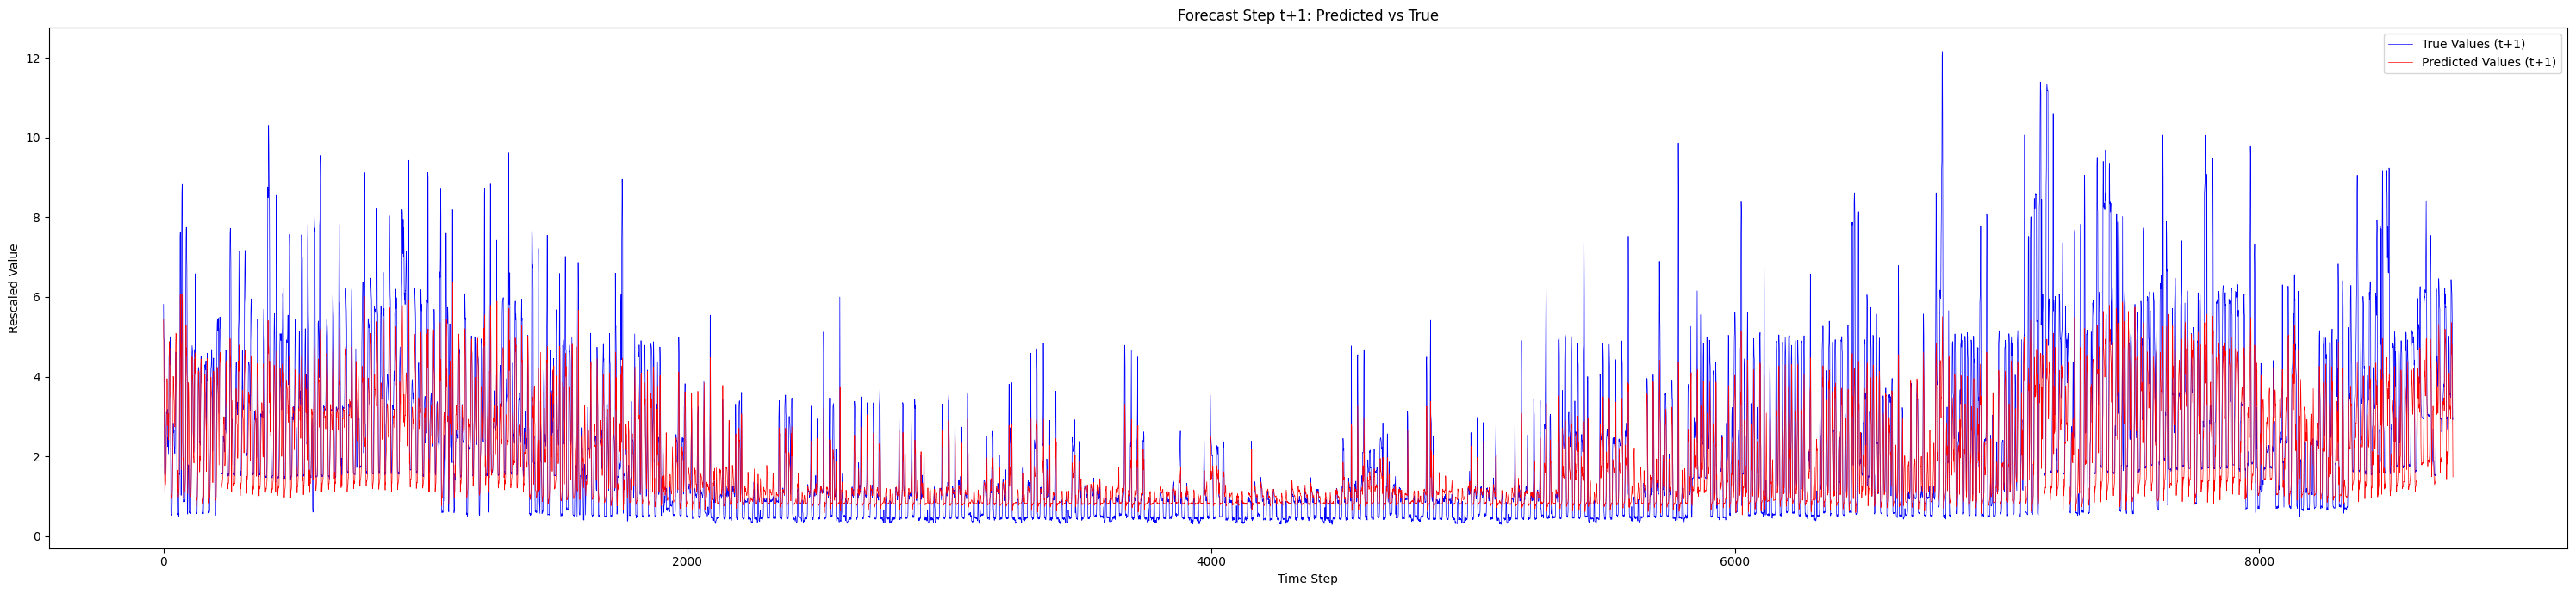

In [9]:
plot_data(y_true_array.flatten(), y_pred_array.flatten())


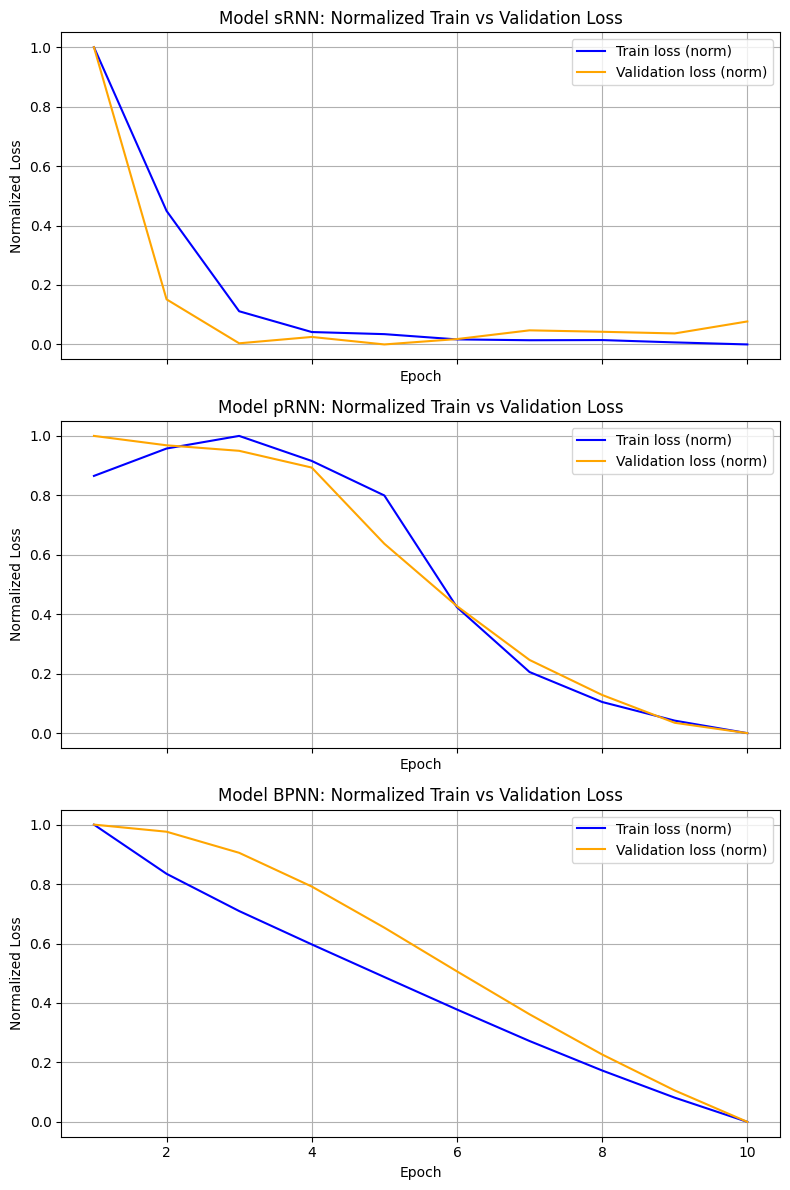

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

log_file = 'logs/loss.csv'
df = pd.read_csv(log_file)

components = df['component'].unique()

titles = {
    's_rnn': 'Model sRNN: Normalized Train vs Validation Loss',
    'p_rnn': 'Model pRNN: Normalized Train vs Validation Loss',
    'bpnn': 'Model BPNN: Normalized Train vs Validation Loss'
}

fig, axs = plt.subplots(len(components), 1, figsize=(8, 4 * len(components)), sharex=True)

if len(components) == 1:
    axs = [axs]

for i, comp in enumerate(components):
    comp_df = df[df['component'] == comp].copy()
    comp_df = comp_df.sort_values('epoch')  # Sort by epoch ascending

    comp_df['train_loss'] = comp_df['train_loss'].astype(float)
    comp_df['val_loss'] = comp_df['val_loss'].astype(float)

    train_min = comp_df['train_loss'].min()
    train_max = comp_df['train_loss'].max()
    val_min = comp_df['val_loss'].min()
    val_max = comp_df['val_loss'].max()

    # Avoid division by zero
    train_range = train_max - train_min if train_max != train_min else 1e-8
    val_range = val_max - val_min if val_max != val_min else 1e-8

    comp_df['train_loss_norm'] = (comp_df['train_loss'] - train_min) / train_range
    comp_df['val_loss_norm'] = (comp_df['val_loss'] - val_min) / val_range

    epochs = comp_df['epoch']

    axs[i].plot(epochs, comp_df['train_loss_norm'], label='Train loss (norm)', color='blue')
    axs[i].plot(epochs, comp_df['val_loss_norm'], label='Validation loss (norm)', color='orange')
    axs[i].set_title(titles.get(comp, f'Model {comp}: Normalized Train vs Validation Loss'))
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Normalized Loss')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()
